# CNN Model using tf.data to read the images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers

import os
import numpy as np

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import datetime

Only run the next two cells if you haven't copied the data onto you machine. 

In [ ]:
#!gsutil -m cp -r dir gs://erwinh-public-data/HotdogData/train ./

In [ ]:
#!gsutil -m cp -r dir gs://erwinh-public-data/HotdogData/eval ./

In [2]:
# set training and eval directory

train_data_dir = pathlib.Path('./train/')
eval_data_dir = pathlib.Path('./eval/')

image_count = len(list(train_data_dir.glob('*/*.jpg')))
image_count

666

In [3]:
# create dataset for training and eval

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

# path to train and eval images
train_image_dir = './train/*/*.jpg'
eval_image_dir = './eval/*/*.jpg'

# create a dataset of the file paths 
list_ds_train = tf.data.Dataset.list_files(train_image_dir)
list_ds_eval = tf.data.Dataset.list_files(eval_image_dir)

# print the path of five images in training set
for f in list_ds_train.take(3):
  print(f.numpy())

b'./train/not_hot_dog/15787.jpg'
b'./train/not_hot_dog/40449.jpg'
b'./train/hot_dog/165005.jpg'


In [4]:
# Specify the class names
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*') if item.name != ".ipynb_checkpoints"])
CLASS_NAMES

array(['not_hot_dog', 'hot_dog'], dtype='<U11')

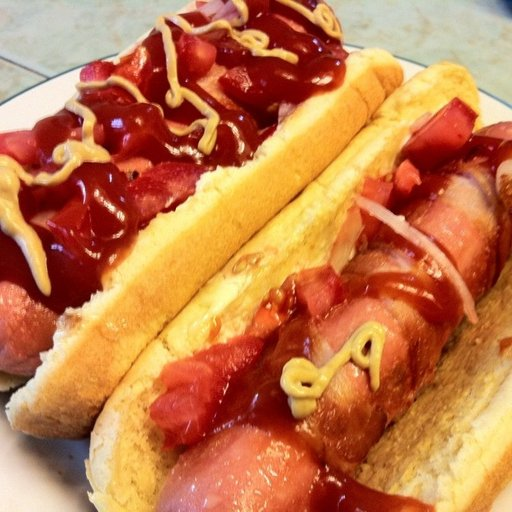

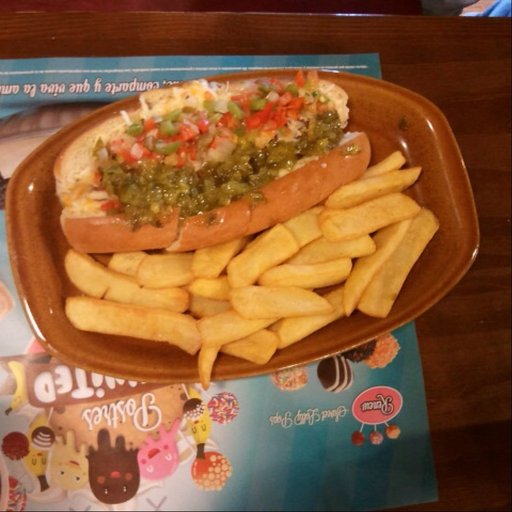

In [5]:
# Inspect some of the images. 

hotdog = list(train_data_dir.glob('hot_dog/*.jpg'))
for image_path in hotdog[:2]:
    display.display(Image.open(str(image_path)))

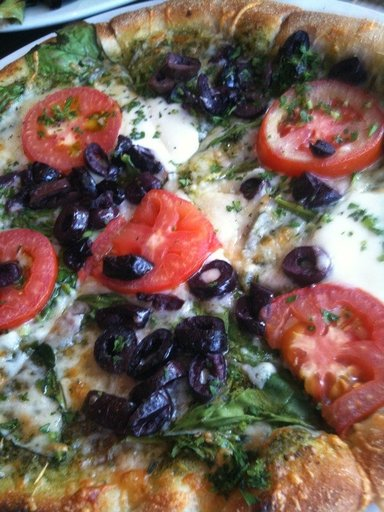

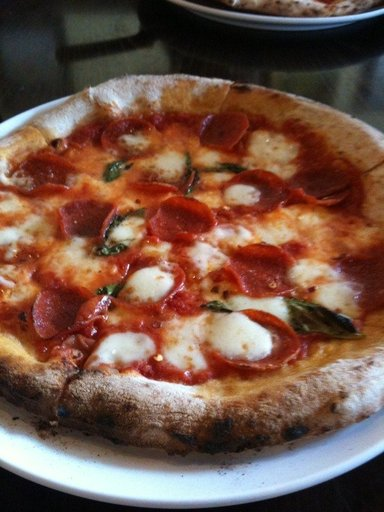

In [6]:
# Inspect some of the images.

hotdog = list(eval_data_dir.glob('not_hot_dog/*.jpg'))
for image_path in hotdog[:2]:
    display.display(Image.open(str(image_path)))

In [7]:
# Specify some of the hyper parameters

batch_size = 32
epochs = 3
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMAGE_SHAPE = (224, 224)
steps_per_epoch = image_count // batch_size
#STEPS_PER_EPOCH = np.ceil(image_count/batch_size)

In [8]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, '/')
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [9]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # flip image
  img = tf.image.flip_left_right(img)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [10]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [11]:
train_labeled_ds = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
eval_labeled_ds = list_ds_eval.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False]


In [13]:
def prepare_for_training(ds, cache=False, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(batch_size)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [14]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [15]:
train_ds = prepare_for_training(train_labeled_ds)
eval_ds = prepare_for_training(eval_labeled_ds)

image_batch, label_batch = next(iter(train_ds))

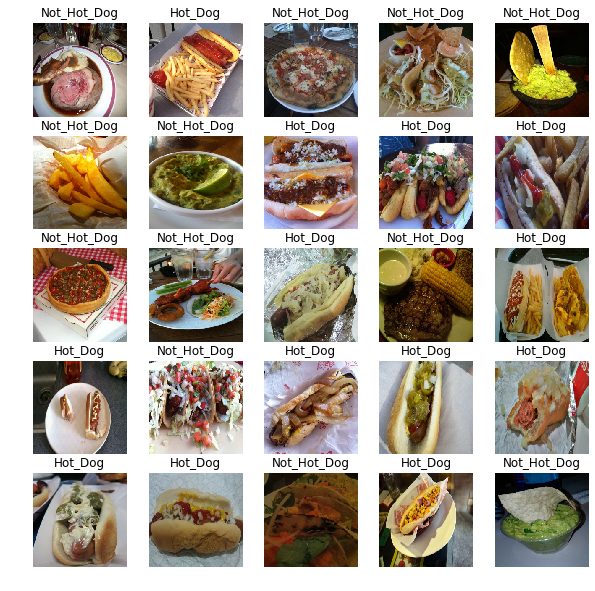

In [16]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [17]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(batch_size*steps/duration))

In [18]:
timeit(train_ds)

....................................................................................................
1000 batches: 38.82295775413513 s
824.25456 Images/s


In [19]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.ResNet152V2(input_shape=(IMG_HEIGHT, IMG_WIDTH , 3),
                                               include_top=False,
                                               weights='imagenet')

In [20]:
base_model.trainable = False

base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [21]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [23]:
prediction_layer = keras.layers.Dense(2, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [24]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
  ])

In [25]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 58,335,746
Trainable params: 4,098
Non-trainable params: 58,331,648
_________________________________________________________________


In [27]:
initial_epochs = 15
steps_per_epoch = steps_per_epoch
validation_steps = steps_per_epoch

#loss0,accuracy0 = model_test.evaluate(eval_ds, steps = validation_steps)

In [28]:
model = model.fit_generator(train_ds,
                    epochs=initial_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    validation_data=eval_ds)

Epoch 1/15
20/20 [==============================] - 253s 13s/step - loss: 0.8816 - accuracy: 0.7297 - val_loss: 1.2777 - val_accuracy: 0.6656
Epoch 2/15
20/20 [==============================] - 251s 13s/step - loss: 0.3979 - accuracy: 0.8445 - val_loss: 1.8199 - val_accuracy: 0.6148
Epoch 3/15
20/20 [==============================] - 250s 12s/step - loss: 0.3599 - accuracy: 0.8586 - val_loss: 0.7966 - val_accuracy: 0.8383
Epoch 4/15
20/20 [==============================] - 252s 13s/step - loss: 0.1944 - accuracy: 0.9258 - val_loss: 1.3926 - val_accuracy: 0.7250
Epoch 5/15
20/20 [==============================] - 250s 12s/step - loss: 0.2546 - accuracy: 0.9031 - val_loss: 2.3712 - val_accuracy: 0.6000
Epoch 6/15
20/20 [==============================] - 251s 13s/step - loss: 0.1825 - accuracy: 0.9211 - val_loss: 0.3510 - val_accuracy: 0.9148
Epoch 7/15
20/20 [==============================] - 250s 13s/step - loss: 0.2792 - accuracy: 0.9023 - val_loss: 1.6217 - val_accuracy: 0.7172
Epoch 

Disclaimer: This is not an official Google product. The sample code provided for an educational purpose.

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

Data from [Kaggle](https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog/data)